In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

from torch import nn

import torch.optim as optim

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer

In [24]:
plt.style.use('ggplot')

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [26]:
data = pd.read_csv('../data/events_dataset.csv')
data .head(3)

,NEvent,1_1_t,1_2_t,1_3_t,1_4_t,2_1_t,2_2_t,2_3_t,2_4_t,3_1_t,...,8_4_t,9_1_t,9_2_t,9_3_t,9_4_t,nClusters,mTheta,theta,mPhi,phi
0,6627,-1.000,-1.000,-1.000,-1.000,65.076,51.367,-1.000,-1.000,-1.000,...,68.628,-1.000,-1.000,-1.000,-1.000,7,61.998024,63.67,109.930928,116.71
1,12188,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,49.864,...,-1.000,48.615,15.015,6.347,47.517,5,58.495331,42.90,199.248767,198.78
2,12453,81.032,52.578,40.545,66.385,77.508,53.961,25.137,49.966,93.214,...,51.562,-1.000,-1.000,-1.000,-1.000,5,49.432327,51.32,224.589127,212.71


In [27]:
df = data.dropna()

In [28]:
len(df)

3952

In [29]:
def add_noise_to_feature(df, feature_name, noise_level=0.05):
    feature_values = df[feature_name].copy()
    std_dev = feature_values[feature_values != -1].std()
    if std_dev == 0 or np.isnan(std_dev):
        return df

    noise = np.random.normal(0, noise_level * std_dev,
                             size=feature_values.shape)

    df[feature_name] = np.where(
        feature_values != -1, feature_values + noise, feature_values)
    return df


def augment_data(df, num_new_rows=100, noise_level=0.05):
    augmented_data = df.copy()

    for _ in tqdm(range(num_new_rows), desc="Augmenting Data"):
        new_row = df.sample(n=1).copy(deep=True)
        for col in new_row.columns:
            if col != 'theta' and col != 'phi':
                new_row = add_noise_to_feature(new_row, col, noise_level)

        augmented_data = pd.concat(
            [augmented_data, new_row], ignore_index=True)

    return augmented_data

In [30]:
df_augmented = augment_data(df, num_new_rows=3, noise_level=0.05)

Augmenting Data: 100%|██████████| 3/3 [00:00<00:00, 48.26it/s]


In [31]:
df_augmented.to_csv(r'..\data\train1.csv', index=False)

In [32]:
data = pd.read_csv('../data/events_dataset.csv')
data .head(3)

,NEvent,1_1_t,1_2_t,1_3_t,1_4_t,2_1_t,2_2_t,2_3_t,2_4_t,3_1_t,...,8_4_t,9_1_t,9_2_t,9_3_t,9_4_t,nClusters,mTheta,theta,mPhi,phi
0,6627,-1.000,-1.000,-1.000,-1.000,65.076,51.367,-1.000,-1.000,-1.000,...,68.628,-1.000,-1.000,-1.000,-1.000,7,61.998024,63.67,109.930928,116.71
1,12188,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,49.864,...,-1.000,48.615,15.015,6.347,47.517,5,58.495331,42.90,199.248767,198.78
2,12453,81.032,52.578,40.545,66.385,77.508,53.961,25.137,49.966,93.214,...,51.562,-1.000,-1.000,-1.000,-1.000,5,49.432327,51.32,224.589127,212.71


In [33]:
len(df_augmented)

3955

In [34]:
df_augmented.head()

,NEvent,1_1_t,1_2_t,1_3_t,1_4_t,2_1_t,2_2_t,2_3_t,2_4_t,3_1_t,...,8_4_t,9_1_t,9_2_t,9_3_t,9_4_t,nClusters,mTheta,theta,mPhi,phi
0,6627,-1.000,-1.000,-1.000,-1.000,65.076,51.367,-1.000,-1.000,-1.000,...,68.628,-1.000,-1.000,-1.000,-1.000,7,61.998024,63.67,109.930928,116.71
1,12188,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,49.864,...,-1.000,48.615,15.015,6.347,47.517,5,58.495331,42.90,199.248767,198.78
2,12453,81.032,52.578,40.545,66.385,77.508,53.961,25.137,49.966,93.214,...,51.562,-1.000,-1.000,-1.000,-1.000,5,49.432327,51.32,224.589127,212.71
3,31010,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,...,-1.000,-1.000,-1.000,-1.000,-1.000,3,43.561613,44.25,230.991035,234.01
4,71181,25.786,13.556,28.669,51.520,25.311,-1.000,20.644,39.511,31.403,...,50.430,30.129,5.871,32.987,49.031,8,37.745833,41.01,138.933653,139.26


In [35]:
df_with_nan = df[df.isnull().any(axis=1)]
df_with_nan.head()

,NEvent,1_1_t,1_2_t,1_3_t,1_4_t,2_1_t,2_2_t,2_3_t,2_4_t,3_1_t,...,8_4_t,9_1_t,9_2_t,9_3_t,9_4_t,nClusters,mTheta,theta,mPhi,phi


In [36]:
len(df_augmented)

3955

In [37]:
# X = df.drop(columns=["theta", "phi", "NEvent",
#             'nClusters', 'mTheta', 'mPhi']).values
# y = df[["theta"]].values

In [38]:
X_train = df_augmented.drop(columns=["theta", "phi", "NEvent",
                                     'nClusters', 'mTheta', 'mPhi']).values
y_train = df_augmented[["theta", "phi"]].values

In [39]:
X_val = df.drop(columns=["theta", "phi", "NEvent",
                         'nClusters', 'mTheta', 'mPhi']).values
y_val = df[["theta", "phi"]].values

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [41]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

In [42]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 32)
        self.fc7 = nn.Linear(32, 32)
        self.fc8 = nn.Linear(32, 16)
        self.fc9 = nn.Linear(16, 16)
        self.fc10 = nn.Linear(16, 2)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc5(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc6(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc7(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc8(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc9(x))
        x = self.fc10(x)

        return x

In [43]:
class SimpleModel(nn.Module):
    def __init__(self, input_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 32)
        self.fc7 = nn.Linear(32,  32)
        self.fc8 = nn.Linear(32,  16)
        self.fc9 = nn.Linear(16,  16)
        self.fc10 = nn.Linear(16,  2)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(0.0)

    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc4(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc5(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc6(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc7(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc8(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc9(x))
        x = self.fc10(x)

        return x

In [44]:
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim):
        super(SimpleRegressor, self).__init__()
        # Слой с дроп-аутом
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [45]:
input_dim = X_train_tensor.shape[1]
model = SimpleModel(input_dim).to(device)

In [46]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=30, gamma=0.2)

num_epochs = 100000
best_val_loss = float('inf')
patience = 200
patience_counter = 0

In [148]:
train_losses = []
val_losses = []
best_model_path = 'models/best_model.pth'

In [193]:
pbar = tqdm(range(num_epochs),
            desc="Training Progress - Loss: N/A, Val Loss: N/A", ncols=100, unit="epoch")

for epoch in pbar:
    model.train()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Валидация
    model.eval()
    val_predictions = model(X_val_tensor)
    val_loss = criterion(val_predictions, y_val_tensor)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch,
                    'best_val_loss': best_val_loss}, best_model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    pbar.set_description(f"Epoch [{
                         epoch+1}/{num_epochs}] - Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

Epoch [5275/100000] - Loss: 34.5136, Val Loss: 35.0116:   5%| | 5275/100000 [13:10<3:56:41,  6.67epo

Early stopping at epoch 5276


In [47]:
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])

C:\Users\matsvei\AppData\Local\Temp\ipykernel_11728\2429856813.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model.pth")


<All keys matched successfully>

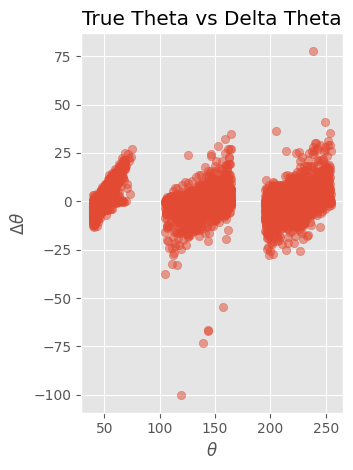

In [52]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(range(len(train_losses[50:])), train_losses[50:], label="Train Loss")
# plt.plot(range(len(val_losses[50:])), val_losses[50:], label="Validation Loss")
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Training and Validation Loss')


model.eval()
all_predictions = model(X_val_tensor).cpu().detach().numpy()

true_theta = y_val_tensor.cpu().detach().numpy()

pred_theta = all_predictions

delta_theta = true_theta - pred_theta

plt.subplot(1, 2, 2)
plt.scatter(true_theta, delta_theta, alpha=0.5)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\Delta \theta$')
plt.title('True Theta vs Delta Theta')

plt.tight_layout()
plt.show()

In [53]:
preds = pred_theta

In [54]:
pred_theta = [pred[0] for pred in preds]
pred_phi = [pred[1] for pred in preds]

In [55]:
d_theta = df['theta'].to_numpy()
cl_theta = df['mTheta'].to_numpy()
pred_theta = np.array(pred_theta)

In [56]:
d_phi = df['phi'].to_numpy()
cl_phi = df['mPhi'].to_numpy()
pred_phi = np.array(pred_phi)

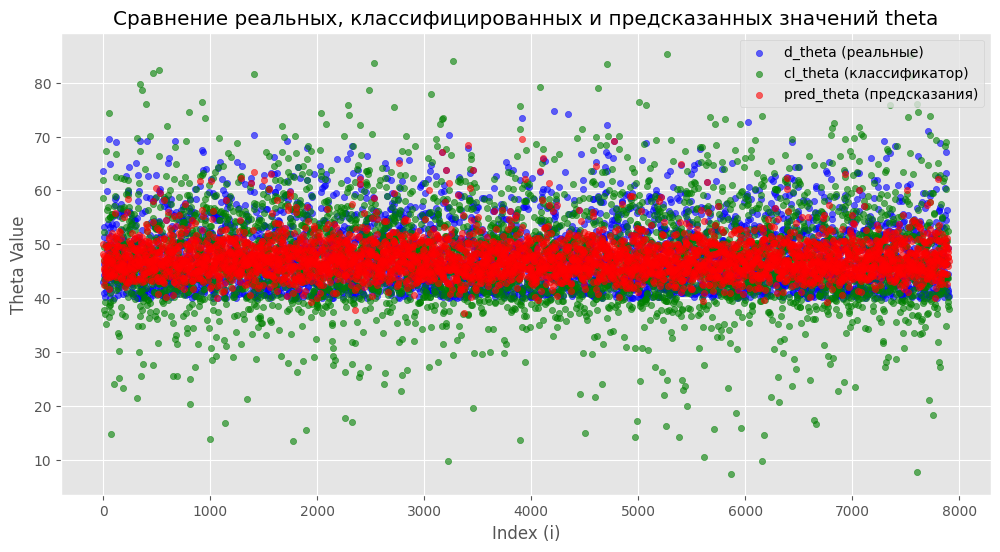

In [200]:
plt.figure(figsize=(12, 6))

# Сжимаем значения по оси X, чтобы точки не сливались
x_values = range(len(d_theta))
# Увеличиваем расстояние между индексами по оси X
expanded_x = [i * 2 for i in x_values]

# Графики
plt.scatter(expanded_x, d_theta, label='d_theta (реальные)',
            c='blue', alpha=0.6, s=20)
plt.scatter(expanded_x, cl_theta, label='cl_theta (классификатор)',
            c='green', alpha=0.6, s=20)
plt.scatter(expanded_x, pred_theta,
            label='pred_theta (предсказания)', c='red', alpha=0.6, s=20)

plt.xlabel('Index (i)')
plt.ylabel('Theta Value')
plt.title('Сравнение реальных, классифицированных и предсказанных значений theta')
plt.legend()
plt.show()

In [201]:
def plot(d_theta, cl_theta, pred_theta):
    plt.figure(figsize=(12, 6))

    # Сжимаем значения по оси X, чтобы точки не сливались
    x_values = range(len(d_theta))
    # Увеличиваем расстояние между индексами по оси X
    expanded_x = [i * 2 for i in x_values]

    # Графики
    plt.scatter(expanded_x, d_theta, label='d_theta (реальные)',
                c='blue', alpha=0.6, s=20)
    plt.scatter(expanded_x, cl_theta, label='cl_theta (классификатор)',
                c='green', alpha=0.6, s=20)
    plt.scatter(expanded_x, pred_theta,
                label='pred_theta (предсказания)', c='red', alpha=0.6, s=20)

    plt.xlabel('Index (i)')
    plt.ylabel('Theta Value')
    plt.title(
        'Сравнение реальных, классифицированных и предсказанных значений theta')
    plt.legend()
    plt.show()

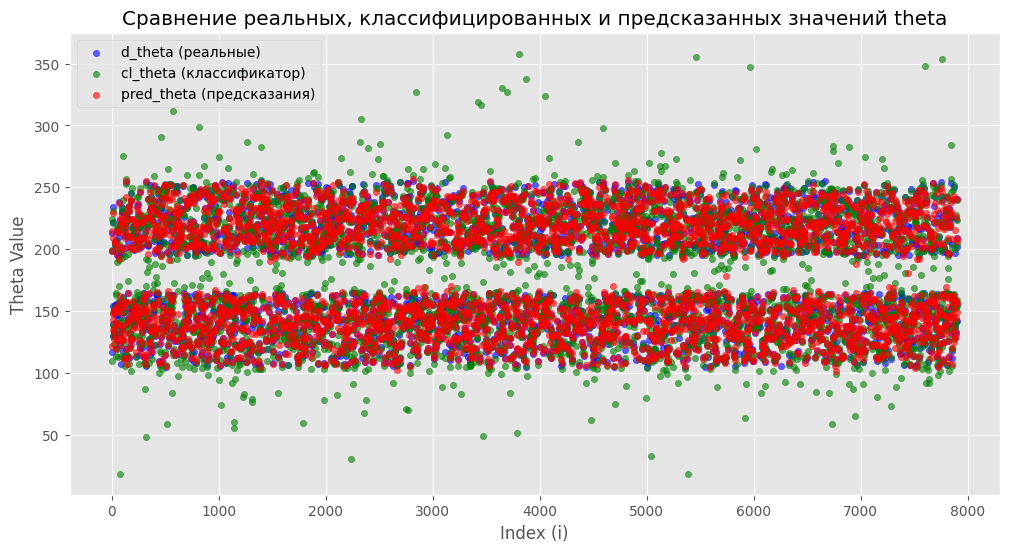

In [202]:
plot(d_phi, cl_phi, pred_phi)

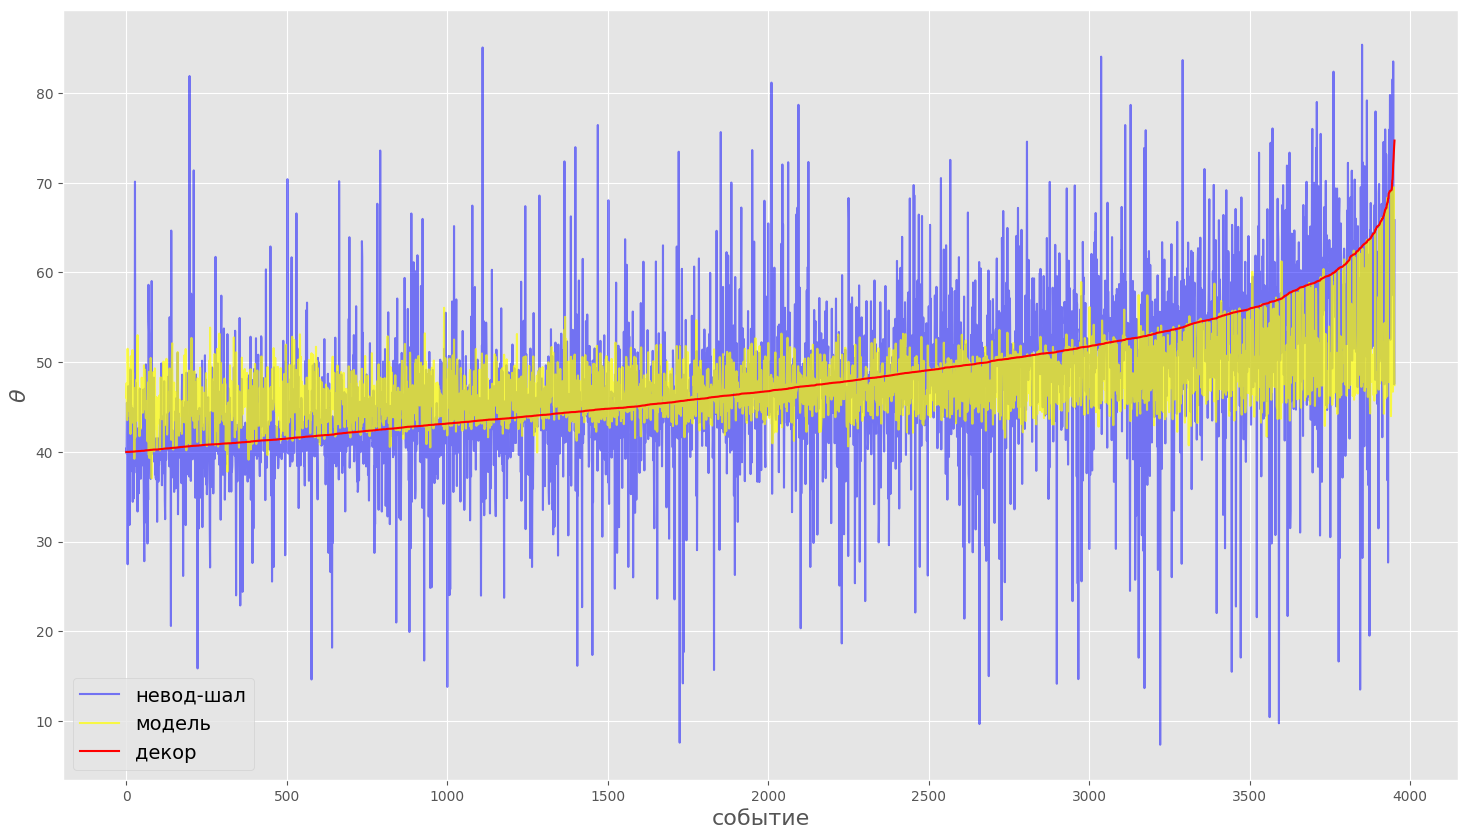

In [57]:
d_theta = df['theta'].to_numpy()
cl_theta = df['mTheta'].to_numpy()
pred_theta = pred_theta

sorted_indices = np.argsort(d_theta)

sorted_d_theta = d_theta[sorted_indices]
sorted_cl_theta = cl_theta[sorted_indices]
sorted_pred_theta = pred_theta[sorted_indices]

plt.figure(figsize=(18, 10))
plt.plot(sorted_cl_theta, label='невод-шал', alpha=0.5, color='blue')
plt.plot(sorted_pred_theta, label='модель',
         alpha=0.7, color='yellow')
plt.plot(sorted_d_theta, label='декор', alpha=1, color='r')

plt.xlabel('событие', fontsize=16)
plt.ylabel(r'$\theta$', fontsize=16)
plt.legend(fontsize=14, loc="best")
# plt.savefig('plots/decor_vs_nn_vs_nevovEAS_theta1.png')
plt.show()

In [204]:
def plot1(d_theta, cl_theta, pred_theta):
    d_theta = df['phi'].to_numpy()
    cl_theta = df['mPhi'].to_numpy()
    pred_theta = pred_theta

    sorted_indices = np.argsort(d_theta)

    sorted_d_theta = d_theta[sorted_indices]
    sorted_cl_theta = cl_theta[sorted_indices]
    sorted_pred_theta = pred_theta[sorted_indices]

    plt.figure(figsize=(18, 10))
    plt.plot(sorted_cl_theta, label='невод-шал', alpha=0.5, color='blue')
    plt.plot(sorted_pred_theta, label='модель',
             alpha=0.7, color='yellow')
    plt.plot(sorted_d_theta, label='декор', alpha=1, color='r')

    plt.xlabel('событие', fontsize=16)
    plt.ylabel(r'$\theta$', fontsize=16)
    plt.legend(fontsize=14, loc="best")
    # plt.savefig('plots/decor_vs_nn_vs_nevovEAS_theta1.png')
    plt.show()

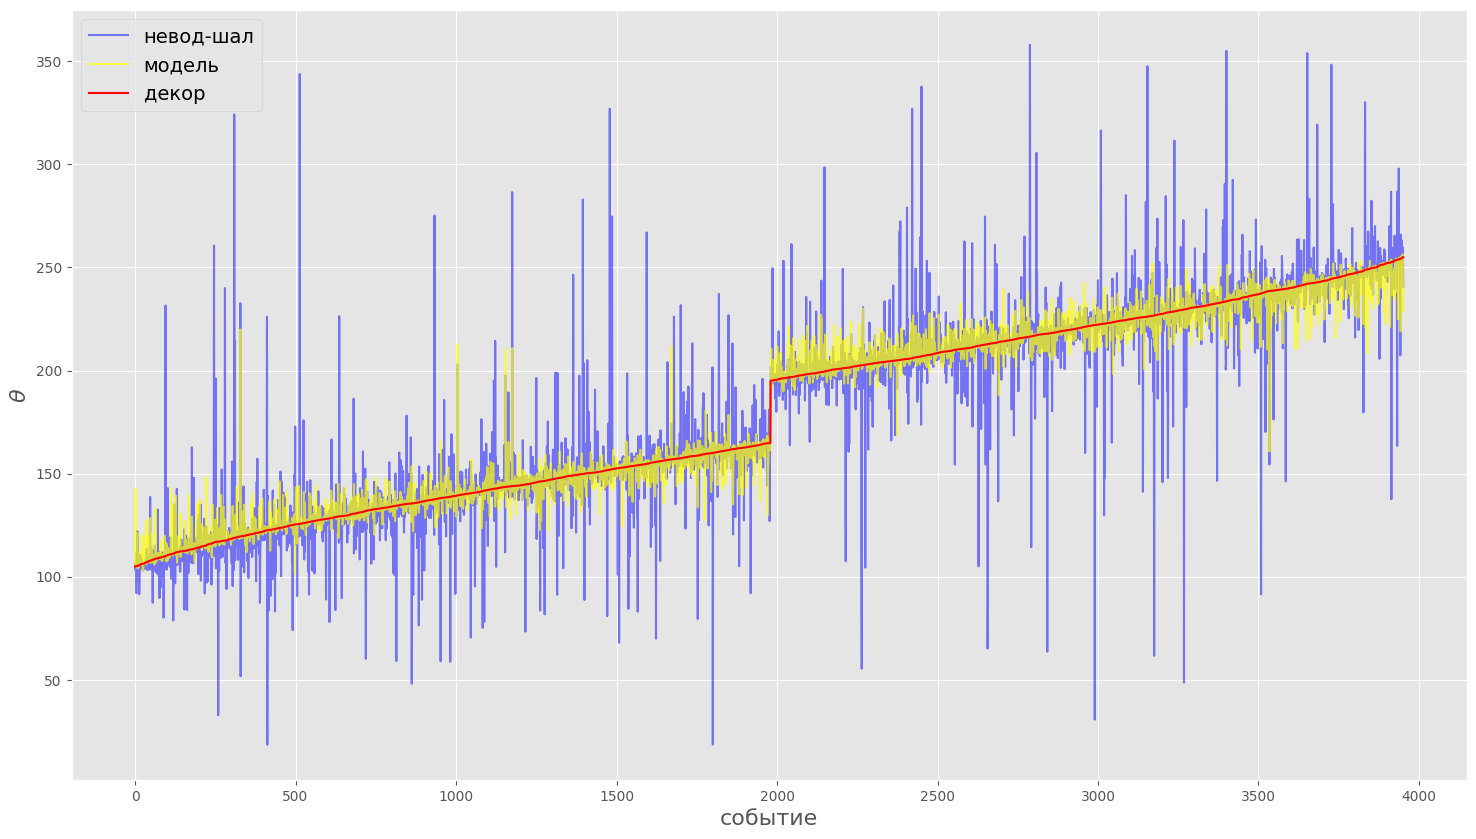

In [205]:
plot1(d_phi, cl_phi, pred_phi)

In [16]:
d_theta = df['theta'].to_numpy()
cl_theta = df['mTheta'].to_numpy()

d_phi = df['phi'].to_numpy()
cl_phi = df['mPhi'].to_numpy()

error_matrix = np.array([
    (d_theta - cl_theta) ** 2,  # Ошибка для θ
    (d_phi - cl_phi) ** 2       # Ошибка для φ
])

# Суммируем по строкам (по столбцам ошибок)
mse_combined = np.mean(np.sum(error_matrix, axis=0))

# Вывод результата
print(f'Общий MSE для матрицы ошибок: {np.sqrt(mse_combined)}')

Общий MSE для матрицы ошибок: 20.925520917040792


In [103]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import matplotlib.ticker as ticker
plt.style.use('default')
mpl.rcParams.update({
    'font.family': 'Arial',
    'axes.linewidth': 1.5,
    'axes.edgecolor': 'black',
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'font.size': 18,
    'axes.labelsize': 26,
    'axes.titlesize': 22,
    'legend.fontsize': 26,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'legend.title_fontsize': 14,
    'legend.framealpha': 0.9,
    'mathtext.default': 'regular'
})


In [146]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

def plot_delta_theta_histogram(d_theta, cl_theta, pred_theta, bin_width=1.0, limit=15, save=False):
    delta_cl = d_theta - cl_theta
    delta_pred = d_theta - pred_theta

    fig, ax = plt.subplots(figsize=(12, 8))

    legend_elements = []

    legend_elements.append(Line2D([0], [0], color='royalblue', linewidth=2.5, label=r'$\Delta \theta = \theta_{Д} - \theta_{НШ}$'))
    legend_elements.append(Line2D([0], [0], color='crimson', linewidth=2.5, label=r'$\Delta \theta = \theta_{Д} - \theta_{НС}$'))

    for delta, color, label in zip(
        [delta_cl, delta_pred],
        ['royalblue', 'crimson'],
        [r'$\Delta \theta = \theta_D - \theta_{НШ}$', r'$\Delta \theta = \theta_D - \theta_{\mathrm{pred}}$']
    ):
        mean = np.mean(delta)
        abs_dev = np.abs(delta - mean)
        radius = np.percentile(abs_dev, 68)
        lower, upper = mean - radius, mean + radius

        bins = np.arange(-limit, limit + bin_width, bin_width)
        counts, bin_edges = np.histogram(delta, bins=bins, weights=np.ones_like(delta)/len(delta))

        ax.plot(bin_edges[:-1], counts, drawstyle='steps-post', color=color, linewidth=2.5)

        for i in range(len(bin_edges) - 1):
            b_start, b_end = bin_edges[i], bin_edges[i+1]
            if b_end <= lower or b_start >= upper:
                continue
            fill_start = max(b_start, lower)
            fill_end = min(b_end, upper)
            ax.fill_between([fill_start, fill_end], [0, 0], [counts[i], counts[i]],
                            color=color, alpha=0.25)

        ax.axvline(mean, color=color, linestyle='-.', linewidth=2)

        legend_elements.append(Line2D([0], [0], color=color, linestyle='-.', linewidth=2,
                                      label=rf'$\mu_{{\Delta \theta}}=${mean:.1f}°'))

        legend_elements.append(Line2D([0], [0], color=color, alpha=0.25, linewidth=10,
                                      label=f'68% [{lower:.1f}°, {upper:.1f}°]'))

    ax.set_xlabel(r'$\Delta \theta$', color='black', fontsize=22)
    ax.set_ylabel('Вероятность', color='black', fontsize=22)
    ax.set_xlim(-limit, limit)
    ax.set_ylim(0, 0.24)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5, integer=True))

    ax.tick_params(axis='x', colors='black', labelsize=20)
    ax.tick_params(axis='y', colors='black', labelsize=20)
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.legend(handles=legend_elements, loc='best', framealpha=0.9, fontsize=20)
    plt.tight_layout()

    if save:
        os.makedirs("plots", exist_ok=True)
        plt.savefig("plots/delta_theta_histogram_rb.jpg", dpi=500, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


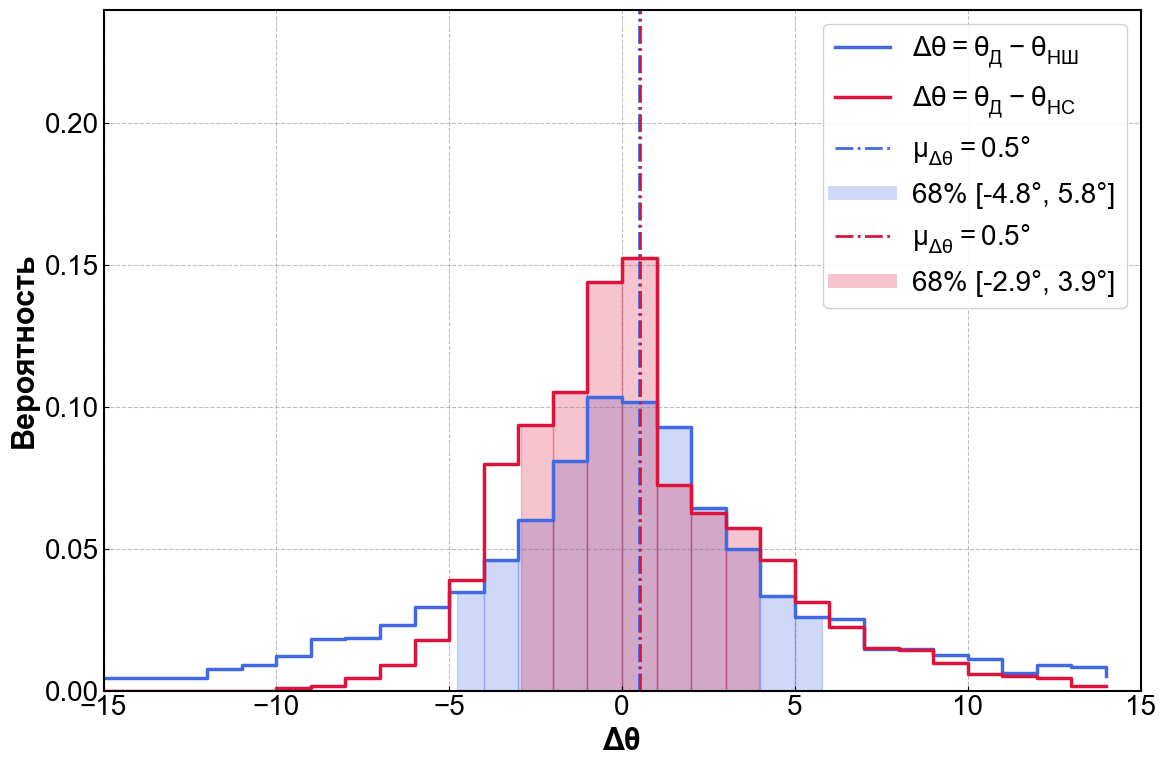

In [145]:
plot_delta_theta_histogram(d_theta, cl_theta, pred_theta)


In [129]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

def plot_delta_phi_histogram(d_theta, cl_theta, pred_theta, bin_width=1.0, limit=15, save=False):
    delta_cl = d_theta - cl_theta
    delta_pred = d_theta - pred_theta

    fig, ax = plt.subplots(figsize=(12, 8))

    legend_elements = []

    legend_elements.append(Line2D([0], [0], color='royalblue', linewidth=2.5, label=r'$\Delta \phi = \phi_{Д} - \phi_{НШ}$'))
    legend_elements.append(Line2D([0], [0], color='crimson', linewidth=2.5, label=r'$\Delta \phi = \phi_{Д} - \phi_{НС}$'))

    for delta, color, label in zip(
        [delta_cl, delta_pred],
        ['royalblue', 'crimson'],
        [r'$\Delta \phi = \theta_D - \theta_{НШ}$', r'$\Delta \theta = \theta_D - \theta_{\mathrm{pred}}$']
    ):
        mean = np.mean(delta)
        abs_dev = np.abs(delta - mean)
        radius = np.percentile(abs_dev, 68)
        lower, upper = mean - radius, mean + radius

        bins = np.arange(-limit, limit + bin_width, bin_width)
        counts, bin_edges = np.histogram(delta, bins=bins, weights=np.ones_like(delta)/len(delta))

        ax.plot(bin_edges[:-1], counts, drawstyle='steps-post', color=color, linewidth=2.5)

        for i in range(len(bin_edges) - 1):
            b_start, b_end = bin_edges[i], bin_edges[i+1]
            if b_end <= lower or b_start >= upper:
                continue
            fill_start = max(b_start, lower)
            fill_end = min(b_end, upper)
            ax.fill_between([fill_start, fill_end], [0, 0], [counts[i], counts[i]],
                            color=color, alpha=0.25)

        ax.axvline(mean, color=color, linestyle='-.', linewidth=2)

        legend_elements.append(Line2D([0], [0], color=color, linestyle='-.', linewidth=2,
                                      label=rf'$\mu_{{\Delta \phi}}=${mean:.1f}°'))

        legend_elements.append(Line2D([0], [0], color=color, alpha=0.25, linewidth=10,
                                      label=f'68% [{lower:.1f}°, {upper:.1f}°]'))

    ax.set_xlabel(r'$\Delta \phi$', color='black', fontsize=22)
    ax.set_ylabel('Вероятность', color='black', fontsize=22)
    ax.set_xlim(-limit, limit)
    ax.set_ylim(0, None)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5, integer=True))

    ax.tick_params(axis='x', colors='black', labelsize=20)
    ax.tick_params(axis='y', colors='black', labelsize=20)
    ax.grid(True, linestyle='--', alpha=0.5)

    ax.legend(handles=legend_elements, loc='best', framealpha=0.9, fontsize=20)
    plt.tight_layout()

    if save:
        os.makedirs("plots", exist_ok=True)
        plt.savefig("plots/delta_phi_histogram_rb.jpg", dpi=500, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


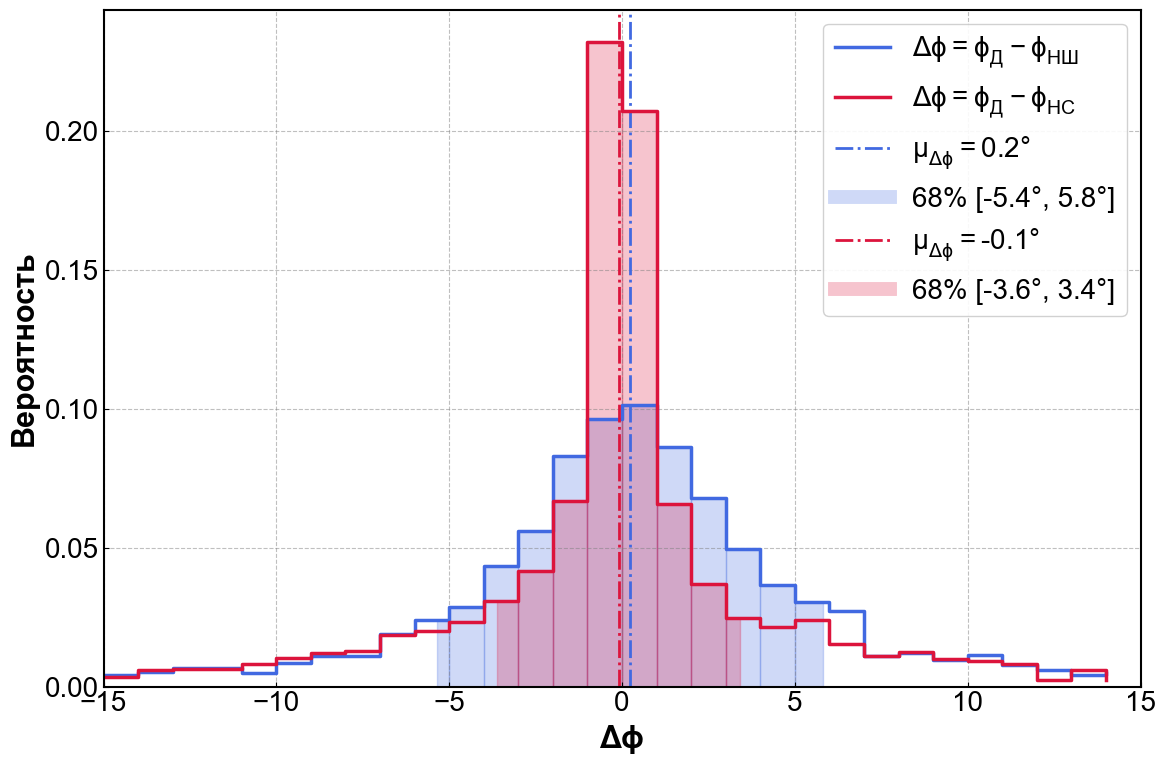

In [130]:
plot_delta_phi_histogram(d_phi, cl_phi, pred_phi)
